In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

import datetime
from pandas.tseries.offsets import DateOffset
from pandas.tseries.offsets import MonthEnd

import statsmodels.api as sm
from scipy import stats
import itertools

import gc

plt.style.use("fivethirtyeight")

In [3]:
path = "bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
#Date conversion
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s",origin="unix")

Text(0.07, 1, 'Missing data check')

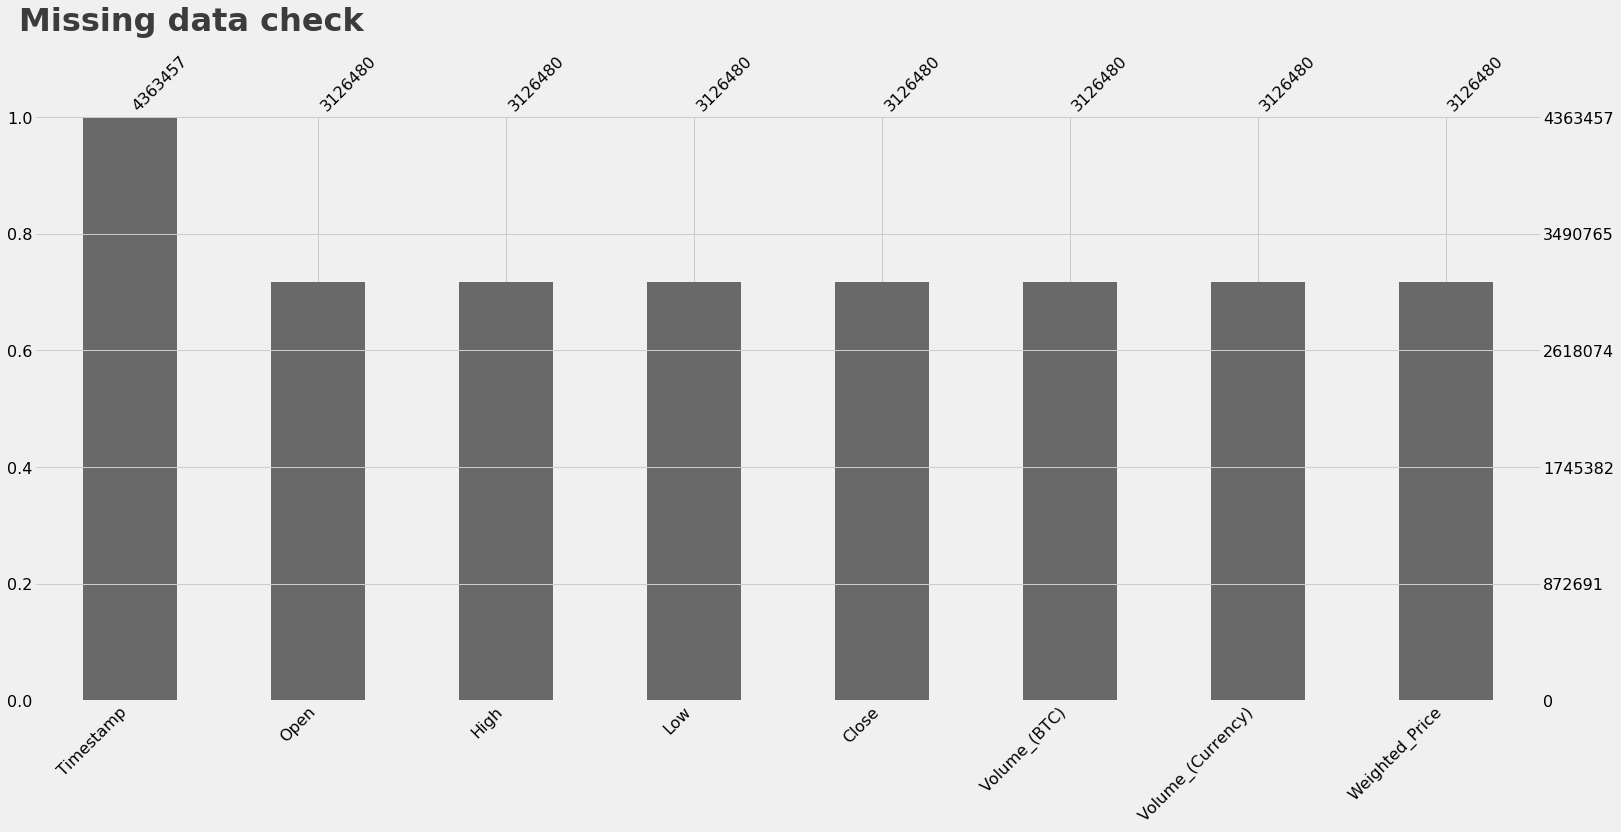

In [31]:
ax, fig = plt.subplots(figsize=(10,5))

msno.bar(df)

ax.text(0.07,1, s="Missing data check", fontsize=32, weight="bold", alpha=0.75)

In [32]:
df.set_index(df["Timestamp"],drop=True,inplace=True)
#Hour
df_hour = df.resample("h").mean()

In [69]:
df_hour.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(2011-6-30 00:00:00, 21000, 'There is no major difference between the mean opening and closing prices.')

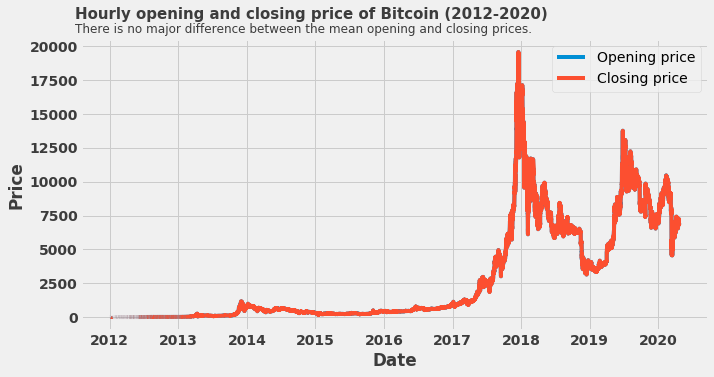

In [80]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Open"], label="Opening price")
plt.plot(df_hour["Close"], label="Closing price")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-6-30 00:00:00", y=22000, s="Hourly opening and closing price of Bitcoin (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=21000, s="There is no major difference between the mean opening and closing prices.",fontsize=12, alpha=0.75)

In [81]:
df_hour["hourly_diff"] = df_hour["Close"] - df_hour["Open"]

No handles with labels found to put in legend.


Text(2011-6-30 00:00:00, 22, 'Larger price fluctuations started happening in 2018 when Bitcoin started gaining mainstream appeal.')

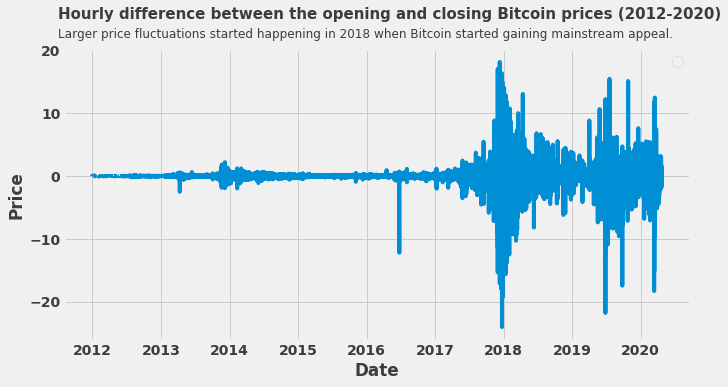

In [85]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["hourly_diff"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-6-30 00:00:00", y=25, s="Hourly difference between the opening and closing Bitcoin prices (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=22, s="Larger price fluctuations started happening in 2018 when Bitcoin started gaining mainstream appeal.",fontsize=12, alpha=0.75)

No handles with labels found to put in legend.


Text(2011-6-30 00:00:00, 21000, 'This is the main metric that we would like to predict.')

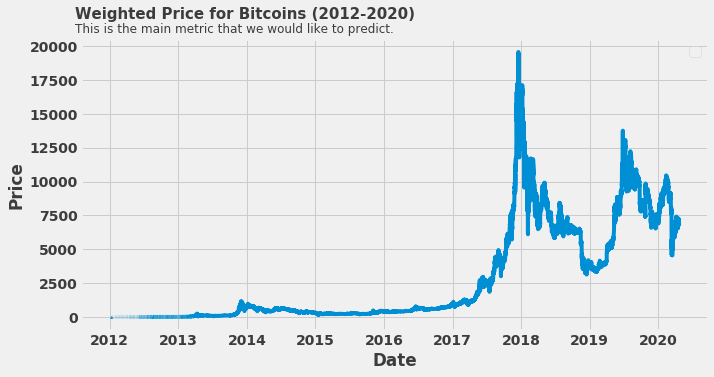

In [87]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_hour["Weighted_Price"])

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-6-30 00:00:00", y=22000, s="Weighted Price for Bitcoins (2012-2020)",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=21000, s="This is the main metric that we would like to predict.",fontsize=12, alpha=0.75)

10266

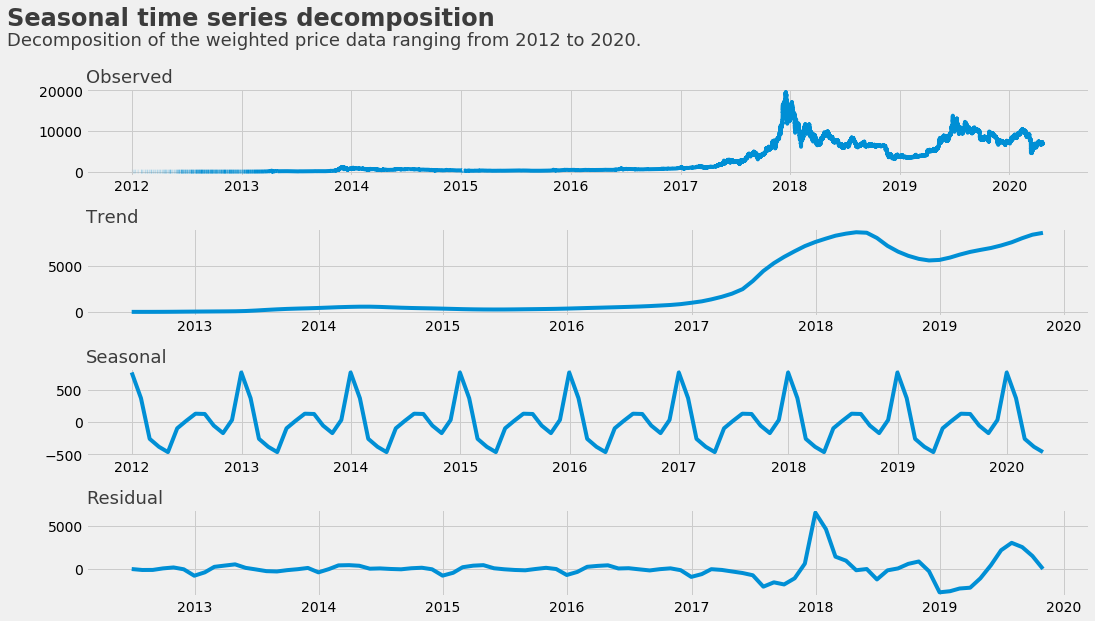

In [120]:
#Seasonal Decompose
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x="2011-6-30 00:00:00", y=63000, s="Seasonal time series decomposition",fontsize=24, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=60700, s="Decomposition of the weighted price data ranging from 2012 to 2020.",fontsize=18, alpha=0.75)

gc.collect()

In [121]:
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Weighted_Price"])[1])

Dicky-Fuller stationarity test - p: 0.419280


In [122]:
#Box-Cox

df_month["Box-Cox"], _ = stats.boxcox(df_month["Weighted_Price"])
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(df_month["Box-Cox"])[1])

Dicky-Fuller stationarity test - p: 0.616565


In [123]:
#Automatic Differencing

first_diff = df_month["Weighted_Price"].diff()
print("Dicky-Fuller stationarity test - p: %f" % sm.tsa.adfuller(first_diff[1:])[1])
print("This series is stationary")


df_month["Auto_Diff"] = first_diff

Dicky-Fuller stationarity test - p: 0.000000
This series is stationary


In [126]:
seasonal_dec = sm.tsa.seasonal_decompose(df_month["Auto_Diff"][1:])

gc.collect()

21357

10327

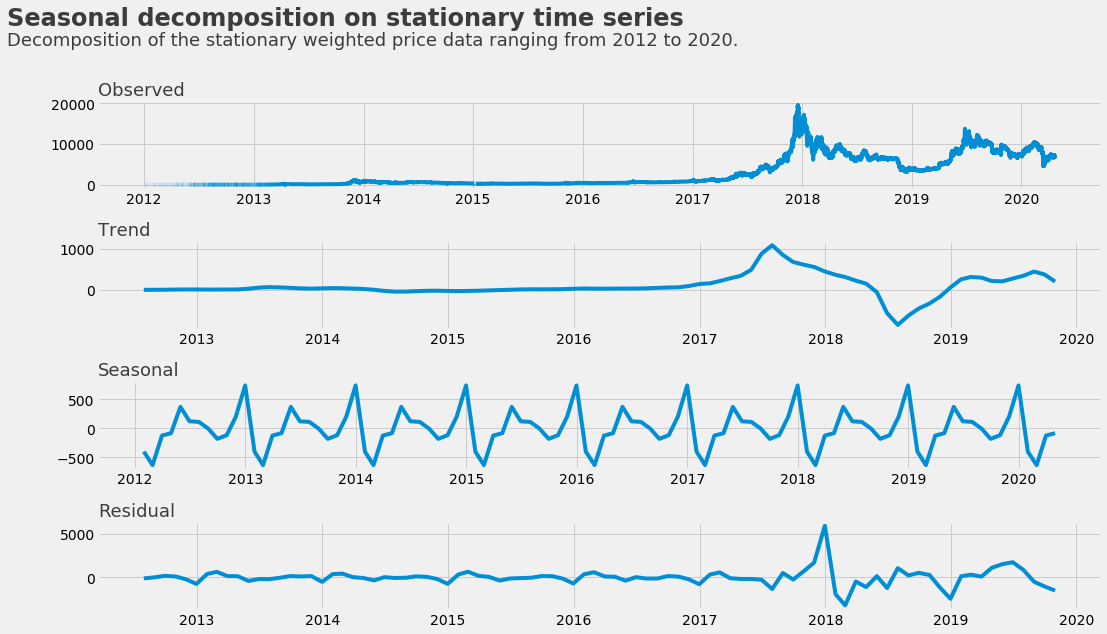

In [127]:
#Seasonal Decompose on stationary series
ax, fig = plt.subplots(figsize=(15,8), sharex=True)

df_month = df.resample("M").mean()
dec = sm.tsa.seasonal_decompose(df_month["Weighted_Price"])


plt.subplot(411)
plt.plot(df_hour["Weighted_Price"], label="Weighted Price")
plt.title("Observed",loc="left", alpha=0.75, fontsize=18)

plt.subplot(412)
plt.plot(seasonal_dec.trend, label="Trend")
plt.title("Trend",loc="left", alpha=0.75, fontsize=18)

plt.subplot(413)
plt.plot(seasonal_dec.seasonal, label="Seasonal")
plt.title("Seasonal",loc="left", alpha=0.75, fontsize=18)

plt.subplot(414)
plt.plot(seasonal_dec.resid, label="Residual")
plt.title("Residual",loc="left", alpha=0.75, fontsize=18)
plt.tight_layout()

plt.text(x="2011-6-30 00:00:00", y=63000, s="Seasonal decomposition on stationary time series",fontsize=24, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=60700, s="Decomposition of the stationary weighted price data ranging from 2012 to 2020.",fontsize=18, alpha=0.75)

gc.collect()

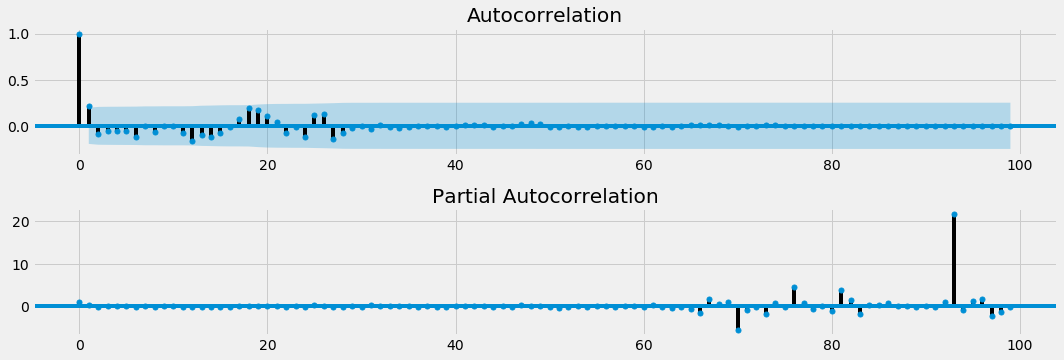

In [133]:
ax, fig = plt.subplots(figsize=(15,10))

plt.subplot(411)
x = sm.graphics.tsa.plot_acf(first_diff[1:], ax=plt.gca())
plt.subplot(412)
y = sm.graphics.tsa.plot_pacf(first_diff[1:],ax=plt.gca())
plt.tight_layout()

gc.collect()
del x,y

In [134]:
###SARIMAX###

p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

In [135]:
def sarimax_function(data,pdq,s_pdq):

    """
    The function uses a brute force approach to apply all possible pdq combinations and evaluate the model
    """

    result_list = []
    for param in pdq:
        for s_param in s_pdq:

            model = sm.tsa.statespace.SARIMAX(data, order=param, seasonal_order=s_param,
            enforce_invertibility=False,enforce_stationarity=False)

            results = model.fit()
            result_list.append([param,s_param,results.aic])
            print("ARIMA Parameters: {} x: {}. AIC: {}".format(param,s_param,results.aic))

    return result_list,results

In [136]:
result_list,results = sarimax_function(df_month["Weighted_Price"],pdq,seasonal_pdq)

gc.collect()

ARIMA Parameters: (0, 0, 0) x: (0, 0, 0, 12). AIC: 1971.3501560130628
ARIMA Parameters: (0, 0, 0) x: (0, 0, 1, 12). AIC: 1737.1606439532673
ARIMA Parameters: (0, 0, 0) x: (0, 1, 0, 12). AIC: 1693.7635334946203
ARIMA Parameters: (0, 0, 0) x: (0, 1, 1, 12). AIC: 1467.5192962182239
ARIMA Parameters: (0, 0, 0) x: (1, 0, 0, 12). AIC: 1713.0329948472806
ARIMA Parameters: (0, 0, 0) x: (1, 0, 1, 12). AIC: 1665.838893258986
ARIMA Parameters: (0, 0, 0) x: (1, 1, 0, 12). AIC: 1482.330981933962
ARIMA Parameters: (0, 0, 0) x: (1, 1, 1, 12). AIC: 1468.5895032827707
ARIMA Parameters: (0, 0, 1) x: (0, 0, 0, 12). AIC: 1833.5107011211114
ARIMA Parameters: (0, 0, 1) x: (0, 0, 1, 12). AIC: 1607.532808472999
ARIMA Parameters: (0, 0, 1) x: (0, 1, 0, 12). AIC: 1589.8426815937216
ARIMA Parameters: (0, 0, 1) x: (0, 1, 1, 12). AIC: 1373.2935449040046
ARIMA Parameters: (0, 0, 1) x: (1, 0, 0, 12). AIC: 1622.288291195978
ARIMA Parameters: (0, 0, 1) x: (1, 0, 1, 12). AIC: 1577.8363717692287
ARIMA Parameters: (0, 0,

63

In [137]:
results_dataframe = pd.DataFrame(result_list, columns=["dpq","s_dpq","aic"]).sort_values(by="aic")
results_dataframe.head()

,dpq,s_dpq,aic
31,"(0, 1, 1)","(1, 1, 1, 12)",1273.860914
63,"(1, 1, 1)","(1, 1, 1, 12)",1273.922449
27,"(0, 1, 1)","(0, 1, 1, 12)",1274.394806
59,"(1, 1, 1)","(0, 1, 1, 12)",1274.892548
55,"(1, 1, 0)","(1, 1, 1, 12)",1290.790096


In [139]:
model = sm.tsa.statespace.SARIMAX(df_month["Weighted_Price"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12),
            enforce_invertibility=False,enforce_stationarity=False).fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2396      0.056      4.281      0.000       0.130       0.349
ar.S.L12      -0.2165      0.150     -1.442      0.149      -0.511       0.078
ma.S.L12      -1.0058      0.071    -14.120      0.000      -1.145      -0.866
sigma2      1.302e+06   5.46e-08   2.39e+13      0.000     1.3e+06     1.3e+06


Text(2011-6-30 00:00:00, 6700, 'Analaysis of the residual values for the best model acording to AIC.')

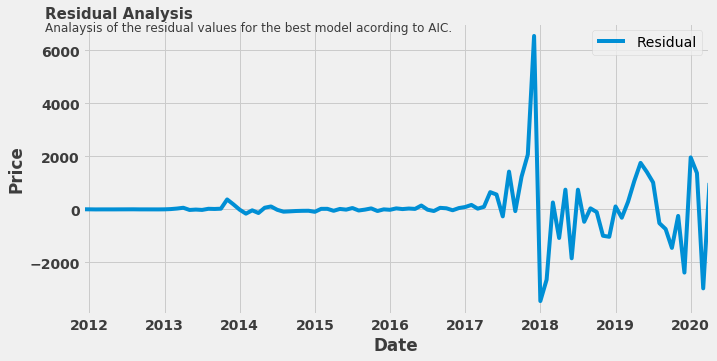

In [144]:
#Residual analysis
ax, fig = plt.subplots(figsize = (10,5))

model.resid.plot(label="Residual")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-6-30 00:00:00", y=7200, s="Residual Analysis",
fontsize=15, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=6700, s="Analaysis of the residual values for the best model acording to AIC.",fontsize=12, alpha=0.75)

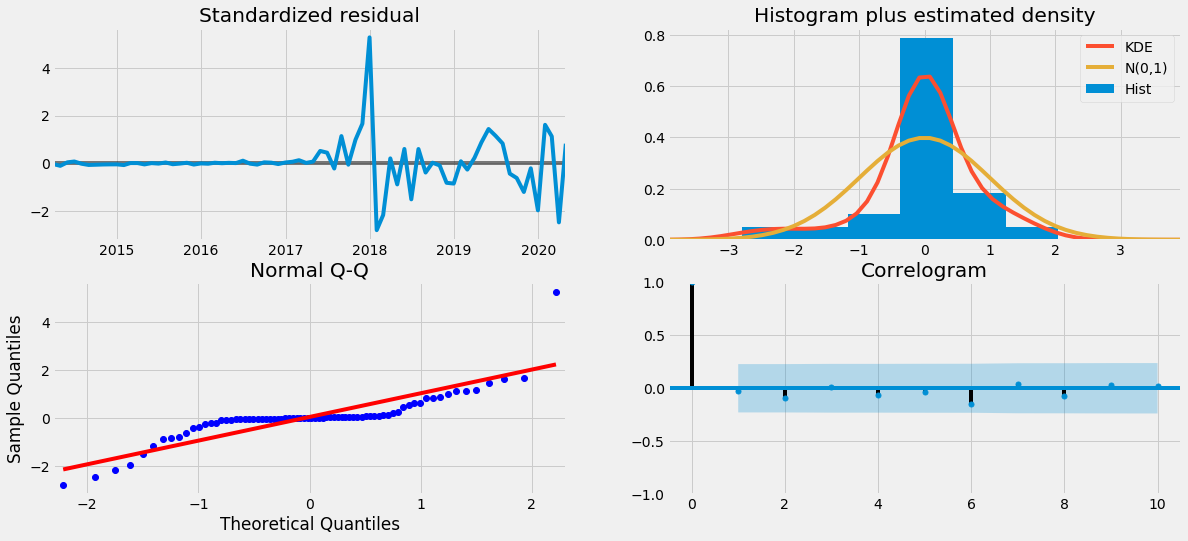

In [161]:
x = model.plot_diagnostics(figsize=(18, 8))

gc.collect()
del x

In [146]:
df_month_prediction = df_month[["Weighted_Price"]]

In [147]:
df_month_prediction["Forcasting"] = model.predict(start=pd.to_datetime("2011-12-31"), end=pd.to_datetime("2020-04-30"))

Text(2011-6-30 00:00:00, 17000, 'Prediction testing of the best SARIMAX model.')

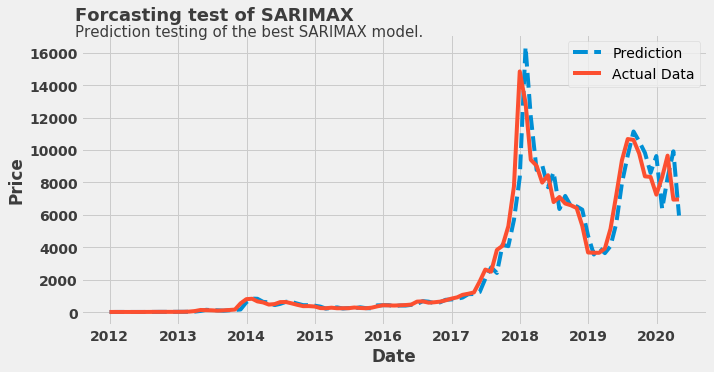

In [154]:
ax, fig = plt.subplots(figsize = (10,5))

plt.plot(df_month_prediction["Forcasting"], ls="--", label="Prediction")
plt.plot(df_month_prediction["Weighted_Price"], label="Actual Data")

plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-6-30 00:00:00", y=18000, s="Forcasting test of SARIMAX",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x="2011-6-30 00:00:00", y=17000, s="Prediction testing of the best SARIMAX model.",fontsize=15, alpha=0.75)

In [155]:
future_dates = [df_month_prediction.index[-1] + DateOffset(months = x)for x in range(1,12)]
future_dates = pd.to_datetime(future_dates)  +  MonthEnd(0)
future = pd.DataFrame(index=future_dates)
df_month_prediction = pd.concat([df_month_prediction,future])

In [171]:
df_month_prediction["Future_forcast"] = model.predict(start=pd.to_datetime("2020-03-31"),end=pd.to_datetime("2021-03-31"))

pred = model.get_prediction(start=pd.to_datetime("2020-03-31"),end=pd.to_datetime("2021-03-31"))
pred_ci = pred.conf_int()

Text(2011-4-30 00:00:00, 18500, 'Prediction of the weighted price for the next 12 months.')

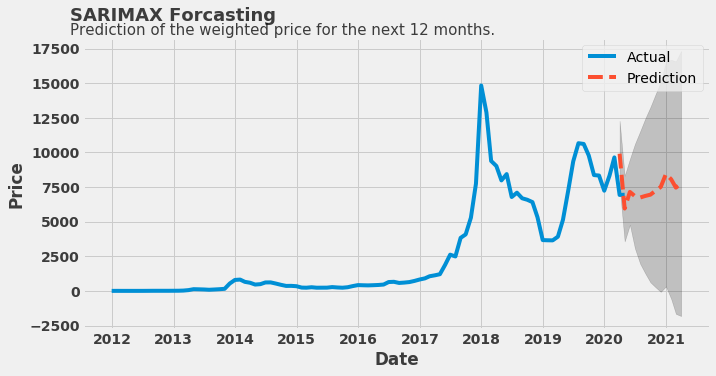

In [178]:
ax, fig = plt.subplots(figsize=(10,5))

plt.plot(df_month_prediction["Weighted_Price"], label="Actual")
plt.plot(df_month_prediction["Future_forcast"],ls="--", label="Prediction")

plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()


plt.xticks(alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Date",alpha=0.75, weight="bold")
plt.ylabel("Price",alpha=0.75, weight="bold")

plt.legend()

plt.text(x="2011-4-30 00:00:00", y=19500, s="SARIMAX Forcasting",
fontsize=18, weight="bold", alpha=0.75)
plt.text(x="2011-4-30 00:00:00", y=18500, s="Prediction of the weighted price for the next 12 months.",fontsize=15, alpha=0.75)